In [46]:
import pickle
import numpy as np
from relate.network import *
from relate.optimizer import *
from sklearn.datasets import load_digits
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

In [47]:
# im2col 卷积快速运算算法  image to column
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N,C,H,W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    # 图像填充
    img = np.pad(input_data, [(0,0), (0,0), (pad,pad), (pad,pad)],'constant')
    # 初始化column
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))
    # 存储方式（batchsize, channel, filter_h, filter_w, out_h, out_w）
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]
    col = col.transpose((0, 4, 5, 1, 2, 3)).reshape(N*out_h*out_w, -1)
    # 转换（batchsize, out_h, out_w, channel, filter_h, filter_w）
    # 为 （行数： batchsize* out_h * out_w , 列数： channel* filter_h* filter_w）
    return col

In [48]:
# col2im 将计算好的矩阵转换为输出图像
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C,
                      filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)
    # 转换为（batchsize, channel, filter_h, filter_w, out_h, out_w）
    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    # 由推导可得 原始图片的大小为（H + 2 * 填补+ 步辐- 1，W + 2 * 填补+ 步辐- 1）
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            # 逆运算，img初始化为零
            img[:, :,y:y_max:stride, x:x_max:stride] +=col[: , :, y, x, :, :]
    # 截取出去pad的内容输出
    return img[:, :, pad:H + pad, pad:W + pad]

In [49]:
# 实现卷积层
class Conv2d:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        # 中间数据（backward时使用）
        self.x = None   
        self.col = None
        self.col_W = None
        # 权重和偏置参数的梯度
        self.dW = None
        self.db = None
    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)
        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)
        self.x = x
        self.col = col
        self.col_W = col_W
        return out
    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)
        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)
        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)
        return dx

In [50]:
# 池化层
class Pooling:
    def __init__(self, pool_h, pool_w, stride=1, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        self.x = None
        self.arg_max = None
    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)
        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)
        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)
        self.x = x
        self.arg_max = arg_max
        return out
    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        return dx

In [51]:
# 搭建简单的卷积神经网络
class SimpleConv:
    def __init__(self,input_dim= (1, 8, 8),
                 conv_param={'filter_num':30,
                            'filter_size':3,
                            'pad':0,
                            'stride':1},
                 hidden_size = 100, output_size=10,weight_init_std= 0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad)/filter_stride + 1
        pool_output_size = int(filter_num*(conv_output_size/2)*(conv_output_size/2))
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)
        # 生成层
        self.layers = OrderedDict()
        self.layers['Conv1'] = Conv2d(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])
        self.last_layer = SoftmaxWithLoss()
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
    def loss(self, x, t):
        y = self.predict(x)
        return self.last_layer.forward(y, t)
    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        acc = 0.0
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        return acc / x.shape[0]
    def numerical_gradient(self, x, t):
        loss_w = lambda w: self.loss(x, t)
        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])
        return grads
    def gradient(self, x, t):
        # forward
        self.loss(x, t)
        # backward
        dout = 1
        dout = self.last_layer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # 设定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)
    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val
        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]        

In [54]:
# 准备数据
digits = load_digits()
data = digits.data
data = data.reshape(-1, 1, 8, 8)
target = digits.target
target = LabelBinarizer().fit_transform(target)
max_epochs = 2000
train_loss_list = []
train_size = data.shape[0]
batch_size = 100
optimizer = 'SGD'
optimizer_param = {'lr':0.01}
network = SimpleConv(input_dim=(1,8,8), 
                        conv_param = {'filter_num': 30, 'filter_size': 3, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
optimizer_class_dict = {'sgd':SGD, 'momentum':Momentum,'adagrad':AdaGrad,'adam':Adam}
optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

for i in range(max_epochs):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = data[batch_mask]
        t_batch = target[batch_mask]
        # 求出梯度
        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)
        # 计算误差
        loss = network.loss(x_batch, t_batch)
        train_loss_list.append(loss)
        

Saved Network Parameters!


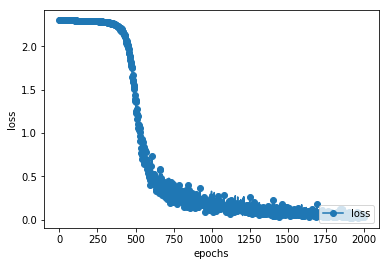

In [55]:
# 保存参数
network.save_params("params.pkl")
print("Saved Network Parameters!")
# 绘制使用SGD训练的图形
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_loss_list, marker='o', label='loss', markevery=2)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc='lower right')
plt.show()

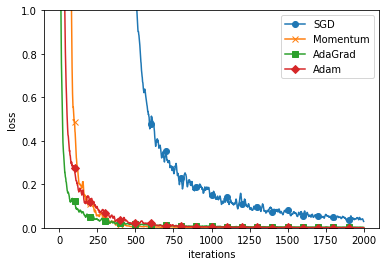

In [57]:
# 模型准备
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = SimpleConv(input_dim=(1,8,8), 
                        conv_param = {'filter_num': 30, 'filter_size': 3, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
    train_loss[key] = []

# 开始训练
for i in range(max_epochs):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = data[batch_mask]
    t_batch = target[batch_mask]
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    if i % 100 == 0:
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
def smooth_curve(x):
    # 用于使损失函数的图形变圆滑
    window_len = 11
    s = np.r_[x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    w = np.kaiser(window_len, 2)
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[5:len(y)-5]

# 绘制图形
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_epochs)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
print('', end='')
#%%